# LEAF CLASSIFICATION PROJECT - CNNs

**TEAM**  
Kaido  
Sander  
Egert

**Training models that can classify leafs**  
**LINK:** https://www.kaggle.com/competitions/leaf-classification/data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import os
# Needs tensorflow 2.10.1
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
# Import data
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')
sample_submission = pd.read_csv('../Data/sample_submission.csv')

In [3]:
np.random.seed(1)

# Preprocessing

In [4]:
# Load and resize images (256x256)
input_folder = "../Data/images"
size = 256
images=[]
for i in range(1,len(os.listdir(input_folder))+1):
    img = Image.open(os.path.join(input_folder, f"{i}.jpg")).convert("1")

    # Resize proportionally
    w, h = img.size
    scale = size / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    resized = img.resize((new_w, new_h), Image.LANCZOS)

    # Create a size x size black background
    output = Image.new("L", (size, size), 0)

    # Paste centered
    x = (size - new_w) // 2
    y = (size - new_h) // 2
    output.paste(resized, (x, y))

    # Add to array
    img_array = np.array(output)
    images.append(img_array)
images = np.array(images)

(1584, 256, 256)


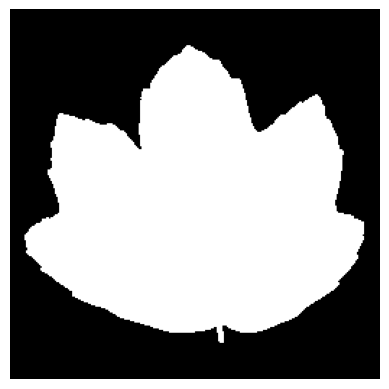

In [5]:
# Show first image
print(images.shape)
plt.imshow(images[0], cmap='gray')
plt.axis('off')
plt.show()

(594, 256, 256)


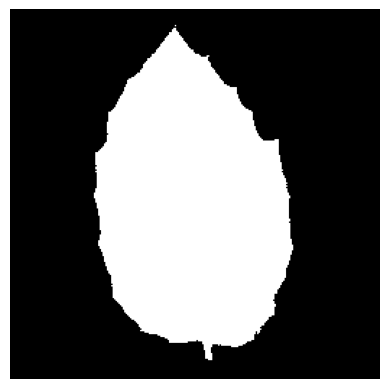

In [6]:
# Seperates test images and shows first image
test_id = test["id"].to_numpy(dtype=int)-1
X_comp = images[test_id]
print(X_comp.shape)

plt.imshow(X_comp[0], cmap='gray')
plt.axis('off')
plt.show()

(990, 256, 256)


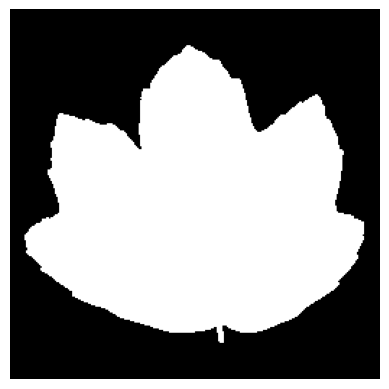

In [7]:
# Seperates training images and shows first image
train_id = train["id"].to_numpy(dtype=int)-1
X = images[train_id]
print(X.shape)

plt.imshow(X[0], cmap='gray')
plt.axis('off')
plt.show()

In [8]:
# Convert y to integers
# Creates encoder and converts strings to integers
le = LabelEncoder()
y = le.fit_transform(train.species)

# Make dict of labels (int->str)
labels = {i: label for i, label in enumerate(le.classes_)}
print(labels)

{0: 'Acer_Capillipes', 1: 'Acer_Circinatum', 2: 'Acer_Mono', 3: 'Acer_Opalus', 4: 'Acer_Palmatum', 5: 'Acer_Pictum', 6: 'Acer_Platanoids', 7: 'Acer_Rubrum', 8: 'Acer_Rufinerve', 9: 'Acer_Saccharinum', 10: 'Alnus_Cordata', 11: 'Alnus_Maximowiczii', 12: 'Alnus_Rubra', 13: 'Alnus_Sieboldiana', 14: 'Alnus_Viridis', 15: 'Arundinaria_Simonii', 16: 'Betula_Austrosinensis', 17: 'Betula_Pendula', 18: 'Callicarpa_Bodinieri', 19: 'Castanea_Sativa', 20: 'Celtis_Koraiensis', 21: 'Cercis_Siliquastrum', 22: 'Cornus_Chinensis', 23: 'Cornus_Controversa', 24: 'Cornus_Macrophylla', 25: 'Cotinus_Coggygria', 26: 'Crataegus_Monogyna', 27: 'Cytisus_Battandieri', 28: 'Eucalyptus_Glaucescens', 29: 'Eucalyptus_Neglecta', 30: 'Eucalyptus_Urnigera', 31: 'Fagus_Sylvatica', 32: 'Ginkgo_Biloba', 33: 'Ilex_Aquifolium', 34: 'Ilex_Cornuta', 35: 'Liquidambar_Styraciflua', 36: 'Liriodendron_Tulipifera', 37: 'Lithocarpus_Cleistocarpus', 38: 'Lithocarpus_Edulis', 39: 'Magnolia_Heptapeta', 40: 'Magnolia_Salicifolia', 41: 'M

In [9]:
# Split X to training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, shuffle=True, random_state=1, stratify=y_val)

In [10]:
# Check if all classes are represented
pd.Series(y_val).value_counts()

86    1
80    1
90    1
46    1
0     1
     ..
3     1
85    1
38    1
82    1
43    1
Name: count, Length: 99, dtype: int64

# Training

In [11]:
# # Best CNNs pipeline

# def multi_scale_block(x, filters=32):
#     # small pattern branch
#     b1 = Conv2D(filters, (1,1), padding='same')(x)
#     b1 = Activation('relu')(b1)
    
#     # medium pattern branch
#     b2 = Conv2D(filters, (3,3), padding='same')(x)
#     b2 = Activation('relu')(b2)

#     # larger context branch
#     b3 = Conv2D(filters, (12,12), padding='same')(x)
#     b3 = Activation('relu')(b3)

#     # merge all
#     return concatenate([b2, b3])

# inp = Input(shape=(256,256,1))

# x = multi_scale_block(inp, 16)
# x = MaxPooling2D((2,2))(x)

# x = multi_scale_block(x, 32)
# x = MaxPooling2D((2,2))(x)

# x = multi_scale_block(x, 64)
# x = MaxPooling2D((3,3))(x)

# x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
# x = MaxPooling2D((4,4))(x)

# x = Flatten()(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.5)(x)

# out = Dense(99, activation='softmax')(x)

# model = Model(inputs=inp, outputs=out)

# model.compile(
#     optimizer="adam",
#     loss="sparse_categorical_crossentropy",
#     metrics=["accuracy"]
# )

# model.summary()

In [12]:
# Define model
def multi_scale_block(x, filters=32):
    # small pattern branch
    b1 = Conv2D(filters, (3,3), padding='same')(x)
    b1 = Activation('relu')(b1)
    
    # medium pattern branch
    b2 = Conv2D(filters, (5,5), padding='same')(x)
    b2 = Activation('relu')(b2)

    # larger context branch
    b3 = Conv2D(filters, (12,12), padding='same')(x)
    b3 = Activation('relu')(b3)

    # merge all
    return concatenate([b1, b2, b3])

inp = Input(shape=(256,256,1))

x = multi_scale_block(inp, 16)
x = MaxPooling2D((2,2))(x)

x = multi_scale_block(x, 32)
x = MaxPooling2D((2,2))(x)

x = multi_scale_block(x, 64)
x = MaxPooling2D((3,3))(x)

x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = MaxPooling2D((4,4))(x)

x = Flatten()(x)
x = Dense(150, activation='relu')(x)
x = Dropout(0.5)(x)

out = Dense(99, activation='softmax')(x)

model = Model(inputs=inp, outputs=out)

model.compile( optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'] )

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  416         ['input_1[0][0]']                
                                )                                                             

In [13]:
# Training model

history = model.fit(X_train, y_train, batch_size=16, epochs=40, validation_data=(X_val,y_val))

Epoch 1/40
50/50 [==============================] - 10s 99ms/step - loss: 16.4675 - accuracy: 0.0215 - val_loss: 4.4527 - val_accuracy: 0.0303
Epoch 2/40
50/50 [==============================] - 3s 63ms/step - loss: 4.3858 - accuracy: 0.0455 - val_loss: 4.0592 - val_accuracy: 0.0909
Epoch 3/40
50/50 [==============================] - 3s 65ms/step - loss: 3.9772 - accuracy: 0.0859 - val_loss: 3.4633 - val_accuracy: 0.1919
Epoch 4/40
50/50 [==============================] - 3s 64ms/step - loss: 3.4812 - accuracy: 0.1465 - val_loss: 2.9504 - val_accuracy: 0.2727
Epoch 5/40
50/50 [==============================] - 3s 62ms/step - loss: 3.1314 - accuracy: 0.2109 - val_loss: 2.5174 - val_accuracy: 0.3333
Epoch 6/40
50/50 [==============================] - 3s 62ms/step - loss: 2.7150 - accuracy: 0.2753 - val_loss: 2.0255 - val_accuracy: 0.3939
Epoch 7/40
50/50 [==============================] - 3s 62ms/step - loss: 2.4361 - accuracy: 0.3207 - val_loss: 1.9191 - val_accuracy: 0.5152
Epoch 8/40


Text(0.5, 1.0, 'Accuracy')

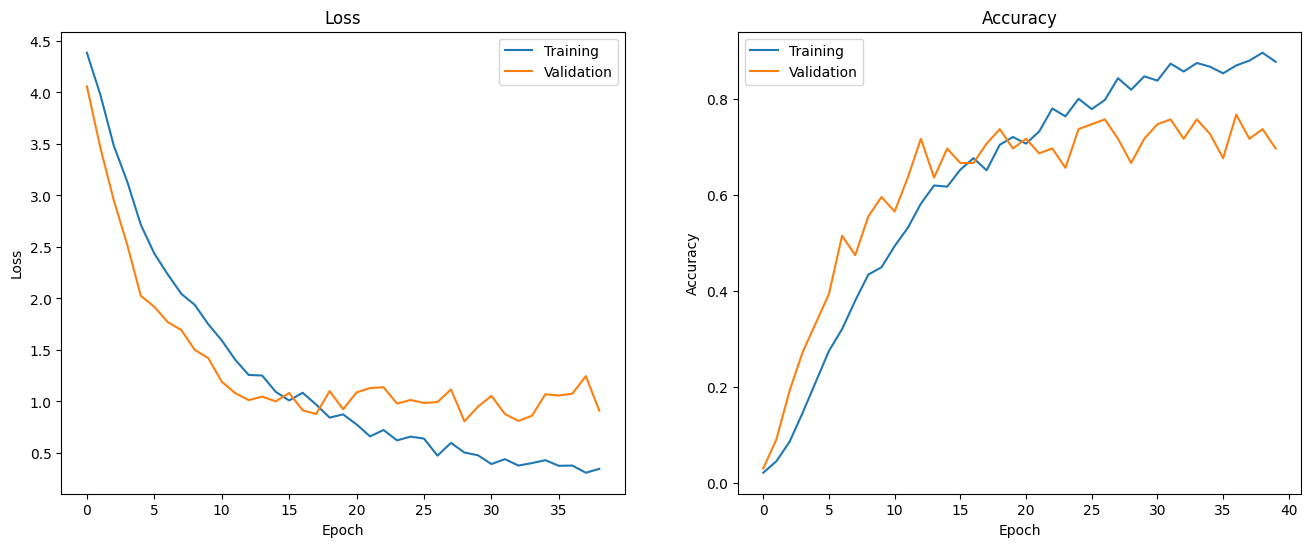

In [14]:
# Visualise the training and validation accuracy and loss dynamics over epochs
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

plt.title('Accuracy')

4/4 [==============================] - 1s 19ms/step
Number of wrong predictions: 24
Accuracy: 0.7575757575757576


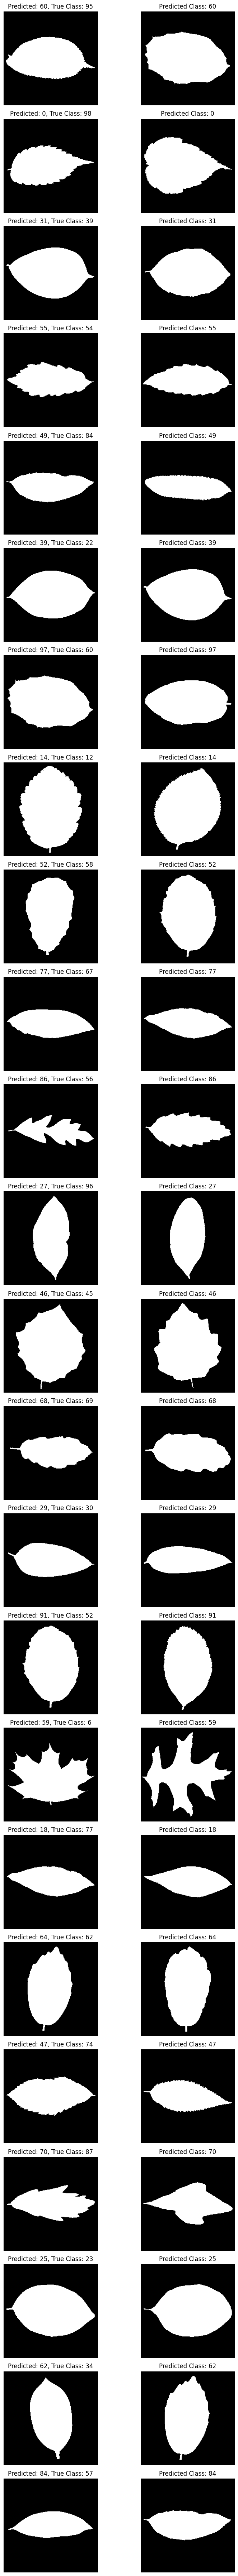

In [15]:
# Show misclassified samples
# Predict
pred_probs = model.predict(X_test)
pred_labels = np.argmax(pred_probs, axis=1)

# Find misclassified samples
wrong_idx = np.where(pred_labels != y_test)[0]

print("Number of wrong predictions:", len(wrong_idx))
print("Accuracy:", 1-len(wrong_idx)/len(X_test))

# Plot some wrong predictions
num_show = len(wrong_idx)

plt.figure(figsize=(12, num_show * 3))

for i, idx in enumerate(wrong_idx[:num_show]):
    img = X_test[idx].squeeze()
    true_label = y_test[idx]
    pred_label = pred_labels[idx]

    # Wrong classes
    plt.subplot(num_show, 3, 3*i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {pred_label}, True Class: {true_label}", color="black")
    plt.axis("off")

    # Find images from the predicted class
    pred_class_idx = np.where(y_test == pred_label)[0]
    correct_img = X_test[pred_class_idx].squeeze()

    plt.subplot(num_show, 3, 3*i + 2)
    plt.imshow(correct_img, cmap='gray')
    plt.title(f"Predicted Class: {pred_label}", color="black")
    plt.axis("off")

    # plt.subplot(num_show, 3, 3*i + 3)
    # plt.imshow(correct_img[1], cmap='gray')
    # plt.title(f"Predicted Class: {pred_label}", color="black")
    # plt.axis("off")

plt.tight_layout()
plt.show()

# Competition

In [16]:
sample_submission

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
1,7,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
2,9,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
3,12,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
4,13,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,1576,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
590,1577,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
591,1579,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
592,1580,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101


In [17]:
# Get predictions
pred_probs = model.predict(X_comp)

19/19 [==============================] - 1s 57ms/step


In [18]:
# Make submission df
submission = pd.DataFrame(pred_probs, columns=le.classes_)
submission.insert(0, 'id', (test_id+1))

In [19]:
submission

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,5.238399e-09,5.409796e-10,2.264037e-11,4.537209e-06,3.399379e-10,4.794977e-08,3.711580e-08,7.712270e-04,1.194737e-04,...,1.283122e-10,1.043568e-12,1.536132e-05,4.016430e-08,2.140543e-09,2.166629e-10,4.703551e-12,1.702400e-04,3.439580e-11,5.380636e-09
1,7,7.705815e-10,1.027464e-08,8.204563e-11,1.389835e-11,1.260929e-09,7.598779e-05,1.521477e-07,2.059453e-08,1.497217e-08,...,2.226060e-08,2.128808e-06,9.583842e-14,2.248518e-12,4.620362e-12,3.273103e-09,1.932059e-07,1.197400e-11,1.977644e-06,2.793213e-04
2,9,5.054709e-08,9.863170e-01,6.271371e-17,1.779953e-04,5.190419e-06,9.222675e-16,2.503509e-06,6.972073e-08,3.935353e-14,...,1.313703e-17,5.226682e-20,5.498971e-14,6.950828e-12,1.299900e-09,1.099169e-06,3.804551e-15,7.154786e-09,1.872312e-10,1.182371e-11
3,12,3.407257e-15,4.663377e-09,2.167568e-12,9.960388e-14,3.425928e-14,7.706388e-13,1.117340e-09,1.317858e-11,1.693587e-08,...,3.016996e-13,1.783700e-09,1.366020e-16,2.756008e-16,6.397846e-16,1.348525e-13,1.097213e-10,5.816435e-12,2.091482e-10,6.245307e-11
4,13,5.037037e-09,3.161123e-12,8.285809e-09,1.703112e-07,5.133396e-09,1.268345e-10,8.224360e-08,1.038600e-08,1.830968e-05,...,2.407644e-10,5.276160e-10,4.389713e-02,2.649557e-05,4.450457e-06,2.333591e-06,7.869961e-10,7.245275e-08,2.648896e-08,3.631827e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,1576,1.252275e-09,9.674990e-01,7.669203e-18,3.222248e-02,1.287722e-07,7.886935e-13,1.906891e-10,7.750076e-08,1.380072e-12,...,1.929393e-15,1.302403e-17,1.030212e-15,3.454508e-10,7.277193e-11,5.329865e-09,1.391796e-15,9.395755e-10,3.974289e-09,1.578964e-10
590,1577,2.180685e-19,5.828277e-18,1.360440e-17,7.532907e-10,5.128937e-18,6.044432e-16,3.064262e-12,6.797119e-08,7.133350e-09,...,4.333757e-16,4.442179e-19,3.698440e-05,2.754313e-10,1.952254e-15,9.043811e-15,4.255965e-18,1.208795e-10,1.119430e-17,8.474253e-15
591,1579,3.204682e-10,8.804839e-10,8.493639e-10,1.510838e-12,2.361809e-13,1.390446e-07,8.477847e-09,4.545170e-11,6.280967e-09,...,1.497663e-11,8.905201e-09,2.028717e-11,4.229760e-10,6.055166e-10,9.609364e-10,7.290908e-05,7.435870e-11,6.896159e-06,4.686792e-08
592,1580,2.371104e-10,1.733292e-07,3.259866e-11,1.193392e-06,1.388865e-07,1.738768e-10,2.056231e-10,2.239683e-08,7.412768e-11,...,2.692751e-08,3.263760e-11,1.539714e-04,4.817994e-13,4.767614e-10,1.129660e-07,1.979152e-14,8.414216e-03,5.588004e-12,1.455550e-09


In [20]:
# Check if all row sum up to 1
submission[le.classes_].sum(axis=1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
589    1.0
590    1.0
591    1.0
592    1.0
593    1.0
Length: 594, dtype: float32

In [21]:
# Save df
submission.to_csv('../Submissions/submission_CNN.csv', index=False)

In [22]:
# Export model
model.save("../Models/CNN")

INFO:tensorflow:Assets written to: ../Models/CNN\assets


INFO:tensorflow:Assets written to: ../Models/CNN\assets


In [23]:
# Import model
from tensorflow import keras
model2 = keras.models.load_model("../Models/CNN")